# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## (1) Import the data and required Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
% matplotlib inline



In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True, )
profile = pd.read_json('data/profile.json', orient='records', lines=True, )
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## (2) Explore the data

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.shape

(10, 6)

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.shape

(17000, 5)

In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
transcript.shape

(306534, 4)

In [9]:
portfolio.groupby('id').sum()

,difficulty,duration,reward
id,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5
2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3
2906b810c7d4411798c6938adc9daaa5,10,7,2
3f207df678b143eea3cee63160fa8bed,0,4,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10
5a8bc65990b245e5a138643cd4eb9837,0,3,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5
ae264e3637204a6fb9bb56bc8210ddfd,10,7,10
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5


In [10]:
persons = transcript.groupby('person').sum().sort_values(by='time',ascending=False).head()
persons

,time
person,
94de646f7b6041228ca7dec82adb97d2,20586
d0a80415b84c4df4908b8403b19765e3,18660
8dbfa485249f409aa223a2130f40634a,18606
edc7b04392144da9979f3077095f268a,17916
acd96146258741999a42ce74856bc119,17910


In [11]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [12]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [13]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

##### Profile dataframe exploration

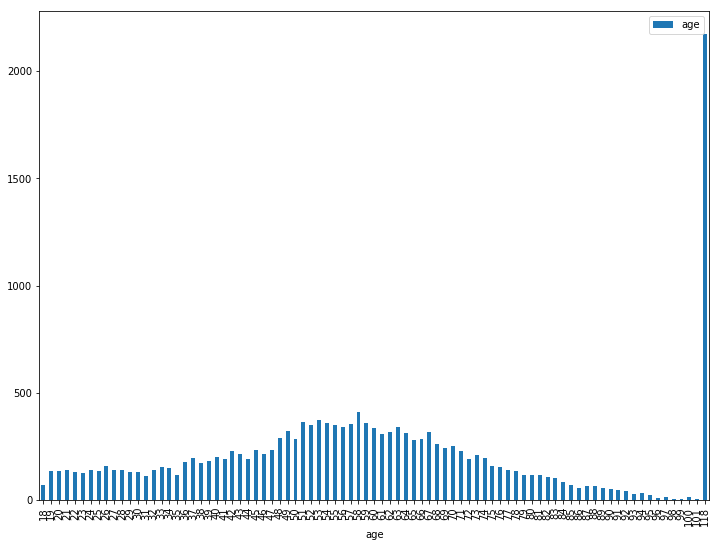

In [14]:
profile.groupby('age')['age',].count().plot(kind='bar',figsize=(12,9))

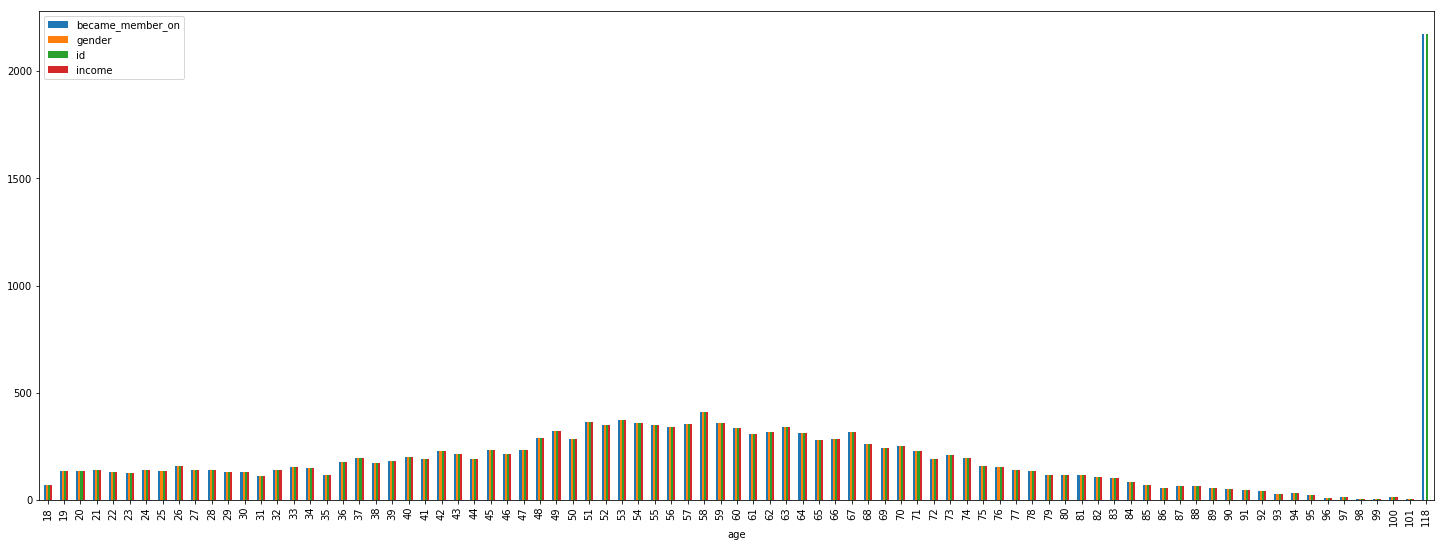

In [15]:
profile.groupby('age').count().plot(kind='bar',figsize=(25,9))

In [16]:
profile[profile.age == 118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [17]:
profile.count()

age                 17000
became_member_on    17000
gender              14825
id                  17000
income              14825
dtype: int64

In [18]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [19]:
profile.shape

(17000, 5)

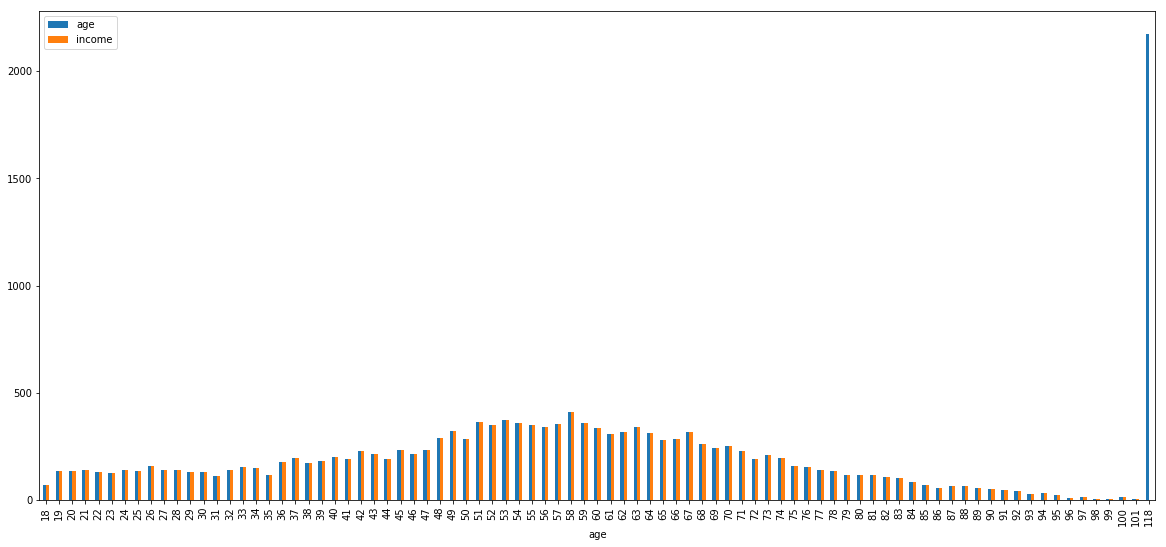

In [20]:
profile.groupby('age')['age','income'].count().plot(kind='bar',figsize=(20,9))

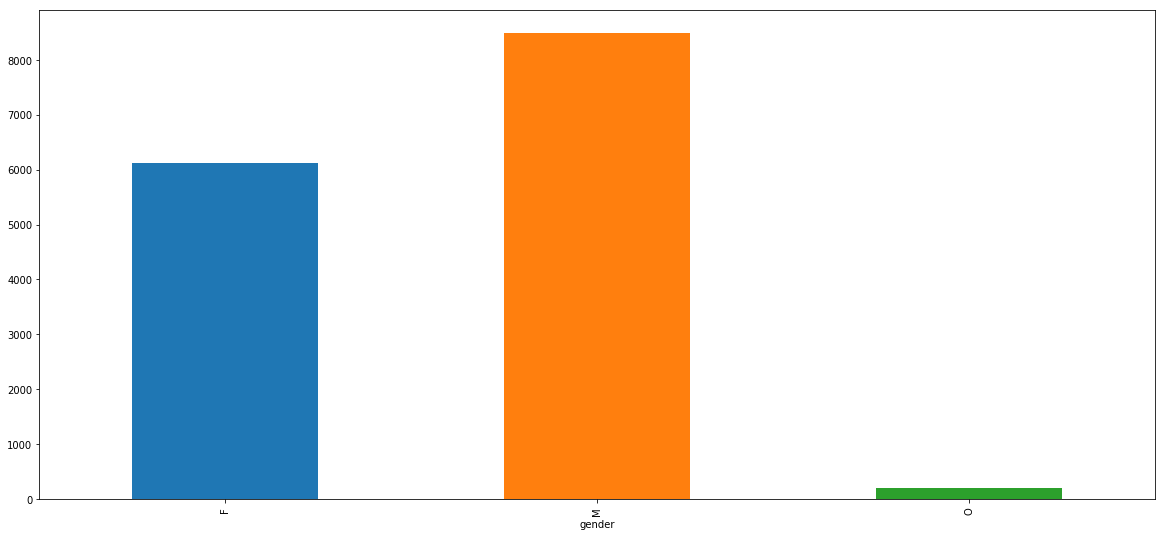

In [21]:
profile.groupby('gender')['gender'].count().plot(kind='bar',figsize=(20,9))

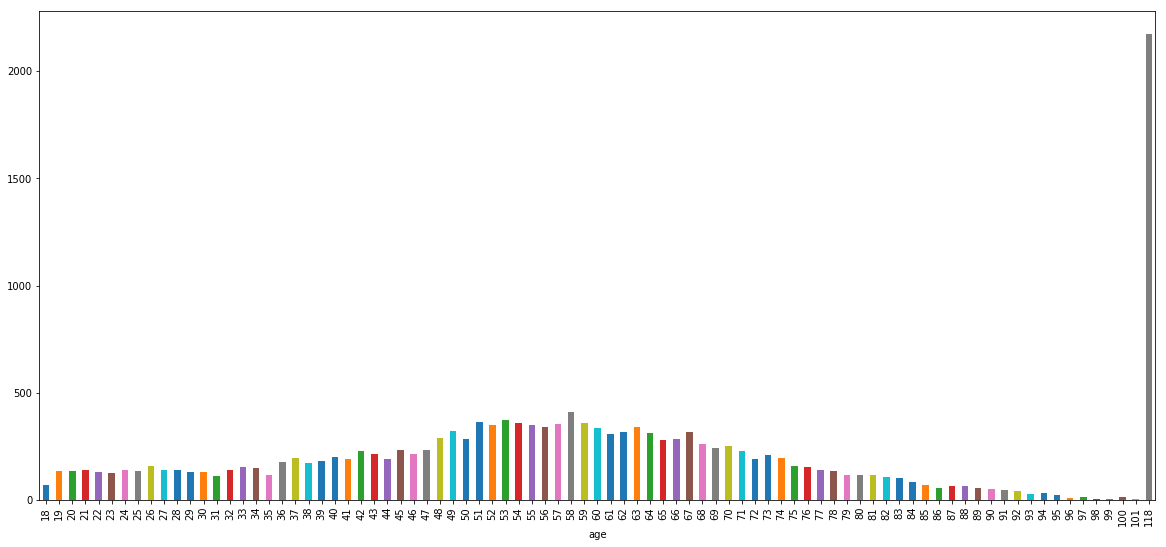

In [22]:
profile.groupby('age')['age'].count().plot(kind='bar',figsize=(20,9))

##### exploring transcript data frame

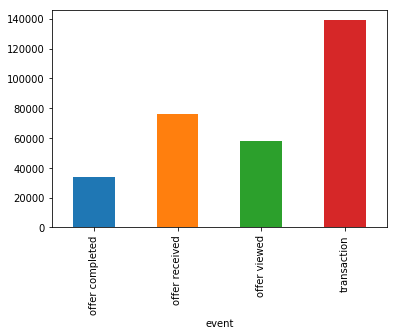

In [23]:
transcript.groupby('event')['event'].count().plot(kind='bar')

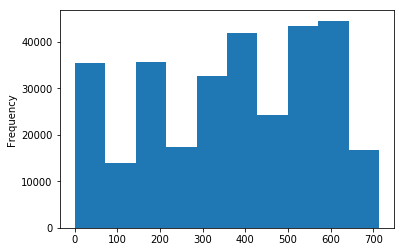

In [24]:
transcript.time.plot(kind='hist')

In [25]:
transcript.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [26]:
transcript.value.head(10)

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6    {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
Name: value, dtype: object

In [27]:
transcript.groupby('person')['person'].count()

person
0009655768c64bdeb2e877511632db8f    20
00116118485d4dfda04fdbaba9a87b5c     7
0011e0d4e6b944f998e987f904e8c1e5    18
0020c2b971eb4e9188eac86d93036a77    19
0020ccbbb6d84e358d3414a3ff76cffd    23
003d66b6608740288d6cc97a6903f4f0    30
00426fe3ffde4c6b9cb9ad6d077a13ea    25
004b041fbfe44859945daa2c7f79ee64    13
004c5799adbf42868b9cff0396190900    26
005500a7188546ff8a767329a2f7c76a    13
0056df74b63b4298809f0b375a304cf4    15
0063def0f9c14bc4805322a488839b32    13
0069a50874d846438e58acff5e594725    11
00715b6e55c3431cb56ff7307eb19675    29
0082fd87c18f45f2be70dbcbb0fb8aad    18
00840a2ca5d2408e982d56544dc14ffd    28
00857b24b13f4fe0ad17b605f00357f5    12
008d7088107b468893889da0ede0df5c    18
0091d2b6a5ea4defaa8393e4e816db60    26
0092a132ead946ceb30d11a1ed513d20    15
0099bf30e4cb4265875266eb3eb25eab    19
009d10c2c38a4fd795a7bc6ddbbddb78    17
00a794f62b9a48beb58f8f6c02c2f1a6    22
00ad4c2cace94f67a6354ec90d6c6f45    18
00ae03011f9f49b8a4b3e6d416678b0b    23
00aee28bbb3848dd8a

In [28]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Cleaning

##### Profile dataframe cleaning

In [29]:
clean_profile = profile.copy()

In [30]:
clean_profile.dropna(axis=0, inplace=True)

In [31]:
clean_profile = clean_profile.rename(columns={'id':'customer_id'})

In [32]:
clean_profile = clean_profile.reindex(columns=['customer_id', 'age', 'became_member_on', 'gender', 'income'])

In [33]:
# replacing the 'customer_id' string values  with easiest numerical values
def map_customer_id(df,col):
    labels_customer_id = df[col].astype('category').cat.categories.tolist()
    map_customer_id = {col : {k: v for k,v in zip(labels_customer_id,list(range(1,len(labels_customer_id)+1)))}}
    df.replace(map_customer_id, inplace=True)
    return df

In [34]:
clean_profile = map_customer_id(clean_profile,'customer_id')

In [35]:
clean_profile.became_member_on = pd.to_datetime(clean_profile.became_member_on, format='%Y%m%d', errors='ignore')

In [36]:
clean_profile['membership_year'] = clean_profile.became_member_on.dt.year
clean_profile.membership_year.head()

1     2017
3     2017
5     2018
8     2018
12    2017
Name: membership_year, dtype: int64

In [37]:
clean_profile['membership_month'] = clean_profile.became_member_on.dt.month
clean_profile.membership_month.head()

1      7
3      5
5      4
8      2
12    11
Name: membership_month, dtype: int64

In [38]:
clean_profile['membership_days'] = datetime.datetime.today().date() - clean_profile['became_member_on'].dt.date
clean_profile.membership_days.head()
clean_profile['membership_days'] = clean_profile['membership_days'].dt.days

In [39]:
# replacing the 'customer_id' string values  with easiest numerical values
labels_gender = clean_profile['gender'].astype('category').cat.categories.tolist()
labels_gender

['F', 'M', 'O']

In [40]:
map_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}

In [41]:
clean_profile.replace(map_gender, inplace=True)

In [42]:
clean_profile.head()

,customer_id,age,became_member_on,gender,income,membership_year,membership_month,membership_days
1,347,55,2017-07-15,1,112000.0,2017,7,1106
3,6963,75,2017-05-09,1,100000.0,2017,5,1173
5,13108,68,2018-04-26,2,70000.0,2018,4,821
8,3247,65,2018-02-09,2,53000.0,2018,2,897
12,2670,58,2017-11-11,2,51000.0,2017,11,987


In [43]:
clean_profile['membership_year'].dtype

dtype('int64')

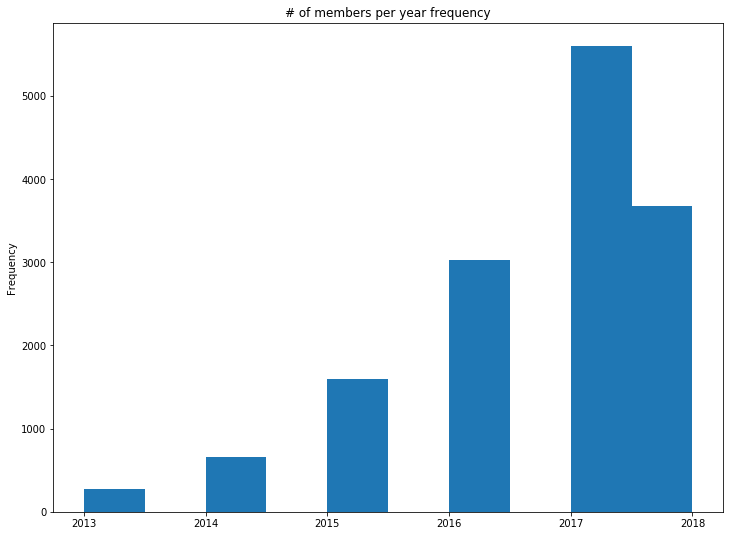

In [51]:
clean_profile['membership_year'].plot(kind='hist',title='# of members per year frequency',figsize=(12,9))

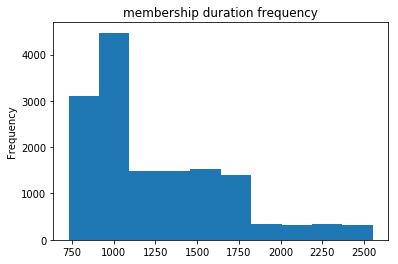

In [45]:
clean_profile['membership_days'].plot(kind='hist', title = 'membership duration frequency', x='membership_days')

In [46]:
clean_profile['membership_days'].describe()

count    14825.000000
mean      1252.478988
std        419.205158
min        730.000000
25%        938.000000
50%       1088.000000
75%       1527.000000
max       2553.000000
Name: membership_days, dtype: float64

##### Transcipt dataframe cleaning

In [47]:
clean_transcript = transcript.copy()

In [48]:
clean_transcript = clean_transcript.rename(columns={'person':'customer_id'})

In [49]:
clean_transcript = clean_transcript.reindex(columns=['customer_id','event','time','value'])

In [50]:
clean_transcript = map_customer_id(clean_transcript,'customer_id')

KeyboardInterrupt: 

In [ ]:
clean_transcript.head()

In [ ]:
clean_transcript.dtypes

##### cleaning portfolio dataframe

In [ ]:
clean_portfolio = portfolio.copy()


In [ ]:
clean_portfolio= clean_portfolio.rename(columns={'id':'customer_id'})

In [ ]:
clean_portfolio = clean_portfolio.reindex(columns=['customer_id','offer_type','dificulty','reward','duration','channels'])

In [ ]:
# replacing the 'customer_id' string values  with easiest numerical values
clean_portfolio = map_customer_id(clean_portfolio,'customer_id')

In [ ]:
clean_portfolio.tail()